In [12]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, Subset
import numpy as np
import matplotlib.pyplot as plt

In [13]:
batch_size = 64
input_size = 784
hidden_size = 100
num_classes = 10
std = 0.4 ## standart deviation of a gaussian noise
learning_rate = 0.001
num_epochs = 50

In [14]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        tensor += torch.normal(mean=self.mean, std=self.std, size=tensor.size())
        tensor = torch.min(torch.ones(tensor.size()), tensor)
        tensor = torch.max(torch.zeros(tensor.size()), tensor)
        return tensor
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [15]:

GaussianNoise = AddGaussianNoise(mean=0, std=std)
PureTransform = transforms.Compose([transforms.ToTensor()])
GaussianTransform = transforms.Compose([transforms.ToTensor(), GaussianNoise])

pure_train_dataset = torchvision.datasets.FashionMNIST(root="./data", train=True, transform=PureTransform, download=True)
perturbed_train_dataset = torchvision.datasets.FashionMNIST(root="./data", train=True, transform=GaussianTransform, download=False)

pure_test_dataset = torchvision.datasets.FashionMNIST(root="./data", train=False, transform=PureTransform, download=False)
perturbed_test_dataset = torchvision.datasets.FashionMNIST(root="./data", train=False, transform=GaussianTransform, download=False)

In [16]:
size = 10000
indices = torch.randperm(size)
train_ind = indices[:int(0.8*size)] # 80 percent for the training set
test_ind = indices[int(0.8*size):size]
train_ind.shape, test_ind.shape


(torch.Size([8000]), torch.Size([2000]))

In [17]:
train_pure = Subset(pure_train_dataset, train_ind[:len(train_ind)//2])
train_perturbed = Subset(perturbed_train_dataset, train_ind[len(train_ind)//2::])

test_pure = Subset(pure_train_dataset, train_ind)
test_perturbed = Subset(perturbed_train_dataset, train_ind)

mixed_train_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.ConcatDataset([train_pure, train_perturbed]), batch_size=batch_size, shuffle = True)
pure_train_loader = torch.utils.data.DataLoader(dataset=train_pure, batch_size=batch_size, shuffle = True)
perturbed_train_loader = torch.utils.data.DataLoader(dataset=train_perturbed, batch_size=batch_size, shuffle = True)
pure_test_loader = torch.utils.data.DataLoader(dataset=test_pure, batch_size=batch_size, shuffle = True) 
perturbed_test_loader = torch.utils.data.DataLoader(dataset=test_perturbed, batch_size=batch_size, shuffle = True) 

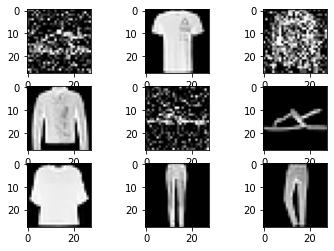

In [18]:
a = iter(mixed_train_loader)
for i, (image, label) in enumerate(a):
    plt.subplot(3,3, i+1)
    plt.imshow(image[0].reshape(28,28), cmap="gray")
    if i == 8: 
        break
plt.show()

In [19]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        return out

model = NeuralNet(input_size, hidden_size, num_classes)

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_total_steps = len(mixed_train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(mixed_train_loader):  
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images = images.reshape(-1, 28*28)
        labels = labels
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            _, predicted = torch.max(outputs.data, 1)
            n_samples = labels.size(0)
            n_correct = (predicted == labels).sum().item()
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}, Accuracy: {n_correct*100.0/len(outputs)}%')


Epoch [1/50], Step [100/125], Loss: 0.8703, Accuracy: 73.4375%
Epoch [2/50], Step [100/125], Loss: 0.6149, Accuracy: 76.5625%
Epoch [3/50], Step [100/125], Loss: 0.5910, Accuracy: 79.6875%
Epoch [4/50], Step [100/125], Loss: 0.7728, Accuracy: 65.625%
Epoch [5/50], Step [100/125], Loss: 0.4136, Accuracy: 87.5%
Epoch [6/50], Step [100/125], Loss: 0.3813, Accuracy: 87.5%
Epoch [7/50], Step [100/125], Loss: 0.5221, Accuracy: 75.0%
Epoch [8/50], Step [100/125], Loss: 0.5214, Accuracy: 81.25%
Epoch [9/50], Step [100/125], Loss: 0.3536, Accuracy: 89.0625%
Epoch [10/50], Step [100/125], Loss: 0.4146, Accuracy: 82.8125%
Epoch [11/50], Step [100/125], Loss: 0.3542, Accuracy: 87.5%
Epoch [12/50], Step [100/125], Loss: 0.4052, Accuracy: 84.375%
Epoch [13/50], Step [100/125], Loss: 0.3398, Accuracy: 87.5%
Epoch [14/50], Step [100/125], Loss: 0.4437, Accuracy: 87.5%
Epoch [15/50], Step [100/125], Loss: 0.3537, Accuracy: 85.9375%
Epoch [16/50], Step [100/125], Loss: 0.3839, Accuracy: 85.9375%
Epoch [

In [21]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in pure_test_loader:
        images = images.reshape(-1, 28*28)
        labels = labels
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the pure dataset: {acc} %')


Accuracy of the pure dataset: 93.1625 %


In [22]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in perturbed_test_loader:
        images = images.reshape(-1, 28*28)
        labels = labels
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the perturbed dataset: {acc} %')


Accuracy of the perturbed dataset: 84.6375 %
